# Clustering the Beaded Helix Transtion from R- to L-Helix

## Import Libraries

In [5]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import pyemma
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch

## Read trajectory

In [6]:
prmtopFileName = "helix_template.pdb"
trajFileName = "helix_folding_eps6.0.dcd"
coord = md.Universe(prmtopFileName,trajFileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('all')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
trajData = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    trajData[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 12
Number of frames in trajectory: 10001
Number of atoms in selection: 12


## Perform Cross Validation Cluster Scan (can take a while)

In this scan, it is possible for divide by zero errors to arise.  This occurs when there are very few (maybe only 1) frame per cluster.  We have only observed this for very simple systems such as this beaded helix example. 

In [7]:
# define cluster array
cluster_array = np.arange(2,8,1).astype(int)

In [5]:
# run cluster CV scan
weighted_train_log_lik, weighted_predict_log_lik = scripts.cross_validate_cluster_scan(trajData,2000,covar_type = "kronecker", cluster_array = cluster_array, n_training_sets=5, n_attempts=10)

Number of frames to train each model: 2000
Number of frames to predict each model: 8001
Number of training sets: 5
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               2               1              39.205           4.408
              1               2               2              40.048           1.208
              1               2               3              39.486           0.586
              1               2               4              40.048           1.688
              1               2               5              40.048           1.814
              1               2               6              39.643           0.830
              1               2               7              39.783           0.982
              1               2               8              40.047

              2               5               5              44.878           1.939
              2               5               6              44.661           2.229
              2               5               7              44.920           3.195
              2               5               8              45.067           2.836
              2               5               9              44.954           2.186
              2               5              10              45.118           3.500
              2               6               1              45.264           2.969
              2               6               2              45.466           5.332
              2               6               3              45.368           2.168
              2               6               4              45.358           2.550
              2               6               5              45.337           1.933
              2               6               6              45.344         

              4               3               3              43.255           1.565
              4               3               4              43.243           1.008
              4               3               5              43.220           1.013
              4               3               6              43.242           1.401
              4               3               7              43.238           1.075
              4               3               8              43.251           1.544
              4               3               9              43.240           1.142
              4               3              10              43.241           1.075
              4               4               1              43.873           1.480
              4               4               2              43.958           2.086
              4               4               3              43.687           1.661
              4               4               4              43.841         

              5               7               1              45.363           2.595
              5               7               2              45.646           4.022
              5               7               3              45.296           2.759
              5               7               4              45.743           4.213
              5               7               5              45.290           4.784
              5               7               6              45.679           4.382
              5               7               7              45.905           3.276
              5               7               8              45.830           3.093
              5               7               9              45.844           6.216
              5               7              10              45.918           5.440


In [12]:
# write to data files
np.savetxt("weighted_train_2_7.dat",np.column_stack((cluster_array,weighted_train_log_lik)))
np.savetxt("weighted_predict_2_7.dat",np.column_stack((cluster_array,weighted_predict_log_lik)))

In [27]:
# load data from txt file if you don't want to run
weighted_train_log_lik = np.loadtxt("weighted_train_2_7.dat")[:,1:]
weighted_predict_log_lik = np.loadtxt("weighted_predict_2_7.dat")[:,1:]

## Make Log Likelihood vs number of Cluster Plots

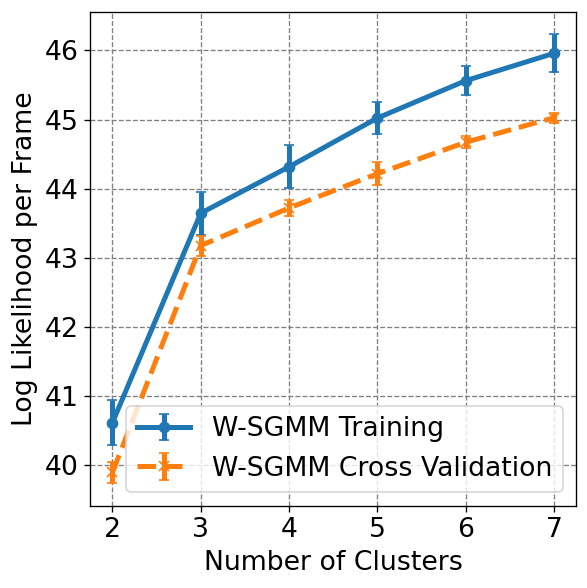

In [7]:
# create figure
plt.figure(figsize=(5,5), dpi= 120, facecolor='w', edgecolor='k')
# weighted SGMM
weighted_train_mean = np.mean(weighted_train_log_lik,axis=1)
weighted_train_std = np.std(weighted_train_log_lik,axis=1)
plt.errorbar(cluster_array,weighted_train_mean,weighted_train_std,fmt='-o',lw=3,capsize=3,label="W-SGMM Training")
#lower, upper = pyemma.util.statistics.confidence_interval((weighted_train_log_lik).T.tolist(), conf=0.9)
#plt.fill_between(cluster_array, lower, upper, alpha=0.3)
weighted_predict_mean = np.mean(weighted_predict_log_lik,axis=1)
weighted_predict_std = np.std(weighted_predict_log_lik,axis=1)
plt.errorbar(cluster_array,weighted_predict_mean,weighted_predict_std,fmt='--x',lw=3,capsize=3,label="W-SGMM Cross Validation")
#lower, upper = pyemma.util.statistics.confidence_interval((weighted_predict_log_lik).T.tolist(), conf=0.9)
#plt.fill_between(cluster_array, lower, upper, alpha=0.3)
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
plt.ylabel("Log Likelihood per Frame",fontsize=16)
plt.xlabel("Number of Clusters",fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
#plt.savefig("beaded_helix_log_likelihood_cv.png",dpi=300,transparent=True)

## Run WSGMM for nClusters=3

In [20]:
n_clusters = 3
delta = 1
n_attempts = 10
objs = []
log_likes = []
for i in range(n_attempts):
    wsgmm = torch_sgmm.ShapeGMMTorch(n_clusters,covar_type='kronecker', kabsch_thresh=1e-1,init_cluster_method='random', dtype=torch.float32, device=torch.device("cuda:0"))
    wsgmm.fit(trajData[1::delta])
    print(i+1, wsgmm.log_likelihood)
    objs.append(wsgmm)
    log_likes.append(wsgmm.log_likelihood)
# select obj with max log likelihood per frame
wsgmm = objs[np.argmax(log_likes)]

1 43.11456439245932
2 43.09874695905263
3 43.119930701387055
4 43.10918666356182
5 43.112379174038864
6 43.12060071923577
7 43.11288244234476
8 43.119941175130286
9 43.12044725996293
10 43.11386712006501


In [11]:
# check cluster populations
print(wsgmm.weights)

[0.46831041 0.39144268 0.14024691]


In [19]:
#predict if you didn't train on entire data set
entire_traj_clusters, entire_traj_traj, entire_traj_log_lik = wsgmm.predict(trajData[1:])

## Make 2D FE Plot with clusterings

In [12]:
from shapeGMM._traj_tools import weight_kabsch_dist_align

In [15]:
mahaClusterCenters = np.empty((trajData[1::delta].shape[0],2),dtype=np.float32)
for frame in range(trajData[1::delta].shape[0]):
    mahaClusterCenters[frame,0] = np.sqrt(weight_kabsch_dist_align(trajData[1::delta][frame].astype(np.float64),wsgmm.centers[0].astype(np.float64),wsgmm.precisions[0]))
    mahaClusterCenters[frame,1] = np.sqrt(weight_kabsch_dist_align(trajData[1::delta][frame].astype(np.float64),wsgmm.centers[1].astype(np.float64),wsgmm.precisions[1]))

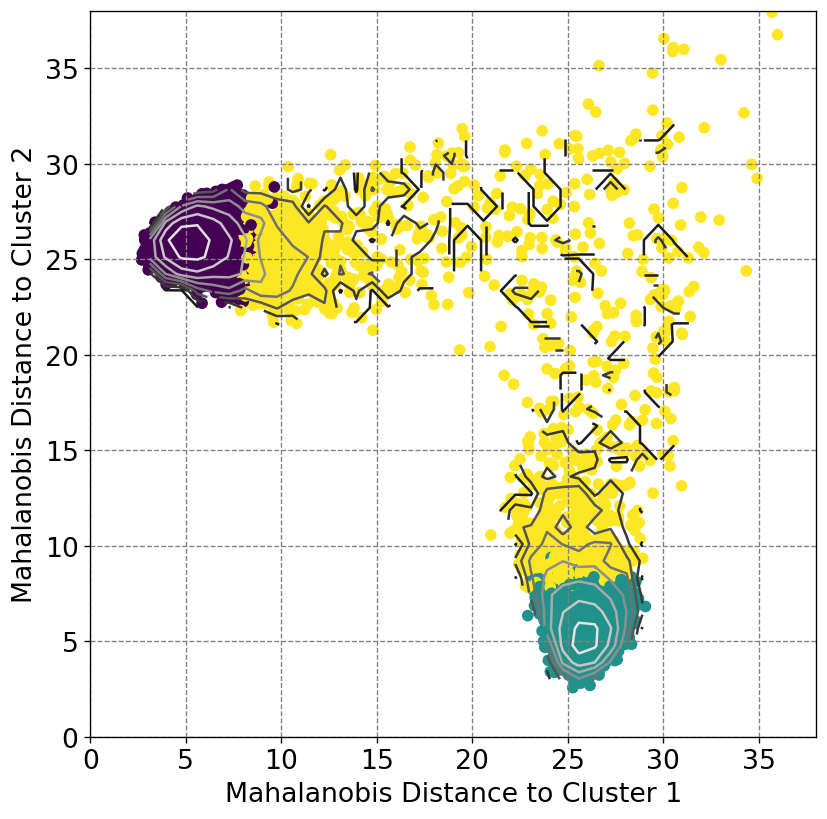

In [16]:
plt.figure(figsize=(7,7), dpi= 120, facecolor='w', edgecolor='k')
x = mahaClusterCenters[:,0]
y = mahaClusterCenters[:,1]
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -np.log(H.T)
xx, yy = np.meshgrid(xcenters, ycenters)
plt.contour(xx,yy,H,cmap='binary')
plt.ylabel("Mahalanobis Distance to Cluster 2",fontsize=16)
plt.xlabel("Mahalanobis Distance to Cluster 1",fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
plt.scatter(mahaClusterCenters[:,0],mahaClusterCenters[:,1],c=wsgmm.clusters)#,alpha=0.2)
plt.tight_layout()
plt.xlim(0,38)
plt.ylim(0,38)
plt.gca().set_aspect('equal')
#plt.savefig("beaded_helix_2D_FE_w_clusters.eps",dpi=300)